In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import tensorflow as tf

df = pd.read_excel('data/state_month_overdose.xlsx')

df['Deaths'] = df['Deaths'].apply(lambda x: 0 if x == 'Suppressed' else int(x))

df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

df = df.reset_index() #2015/01
df['Month Code'] = pd.to_datetime(df['Month Code'])#.reset_index() #2015-01-01
# df.set_index('Month', inplace=True)
df = df.groupby(['Month']).agg({'Deaths': 'sum'}).reset_index()



train = df[df['Month'] <= '2020-02-01']
test = df[df['Month'] >= '2020-02-01']
testog = test
test = test.reset_index().drop(columns = ['index'])



# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset.iloc[i:(i+look_back)] #, 0]
		dataX.append(a)
		dataY.append(dataset.iloc[i + look_back])#, 0])
	return np.array(dataX), np.array(dataY)


look_back = 1
trainX, trainY = create_dataset(train['Deaths'], look_back)
testX, testY = create_dataset(test['Deaths'], look_back)


model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)


trainPredict = model.predict(trainX)
testPredictog = model.predict(testX) 
#default from LSTM - taking into account most recent months for next prediction instead of forecasting forward n months
# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])


print(len(trainX), len(trainPredict))


#GETTING ACTUAL TEST PREDICTIONS
def generate_forecast(model, initial_sequence, num_predictions=12):
    predictions = []
    for_model = initial_sequence
    
    for _ in range(num_predictions):
        # Generate the next prediction
        for_model = model.predict(for_model)
        predictions.append(for_model[0][0])

    return np.array(predictions)


initial_sequence = np.array([trainPredict[-1]]) #because lookback is only 1 month

testPredict = generate_forecast(model, initial_sequence, num_predictions=10)
print('TEST PREDICTIONS')
print(testPredict)

zero = np.array([[0]]) #for the first month input (lookback is 1 month and this month is used for prediction, no prediction for this month)

trainPredictlst = trainPredict.flatten().tolist()
testPredictlst = testPredict.flatten().tolist()

combined_array = [0] + trainPredictlst + testPredictlst

df['LSTM Predictions'] = combined_array





sarima_model = SARIMAX(train['Deaths'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)
sarima_predictions = sarima_result.predict(start=0, end=len(train) + len(test) - 1, dynamic=False)

df['SARIMA Predictions'] = sarima_predictions

df.to_csv('1month_predictionresults.csv')

plottable = df.iloc[1:] #only taking rows with predictions so excluding part included in first lookback
plottable.set_index('Month', inplace=True)

2024-12-18 22:16:19.526384: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 22:16:19.549910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 22:16:19.573870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 22:16:19.580178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 22:16:19.597980: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14353066.0000
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11759743.0000
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8450619.0000
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6001521.0000
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3833508.0000
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1880319.2500
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 755653.2500
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 252957.9062
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94715.5391
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33708.7070
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42722.9102
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45085.5742
Epoch 13/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35226.0078
Epoch 14/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38237.6172

LSTM
Train Score: 203.04 RMSE
Test Score: 1367.60 RMSE
SARIMA
Train Score: 275.38 RMSE
Test Score: 1228.07 RMSE


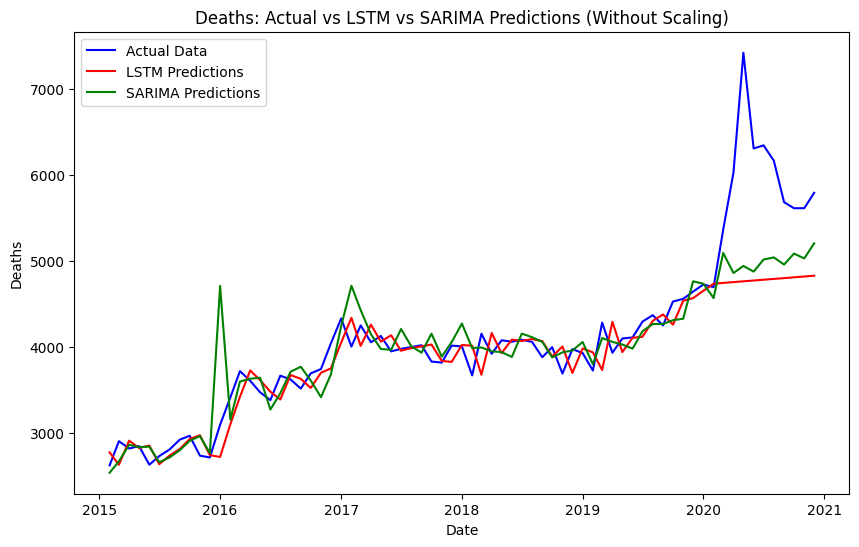

In [2]:
# LSTM calculate root mean squared error
print('LSTM')
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

#SARIMA Error Metrics
print('SARIMA')
trainScore = np.sqrt(mean_squared_error(trainY, sarima_predictions[1:len(trainPredict)+1]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, sarima_predictions[len(trainPredict):-2]))
print('Test Score: %.2f RMSE' % (testScore))

plt.figure(figsize=(10, 6))
plt.plot(plottable.index, plottable['Deaths'], label='Actual Data', color='blue')
plt.plot(plottable.index, plottable['LSTM Predictions'], label='LSTM Predictions', color='red')
plt.plot(plottable.index, plottable['SARIMA Predictions'], label='SARIMA Predictions', color='green')
plt.title('Deaths: Actual vs LSTM vs SARIMA Predictions (Without Scaling)')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.show()

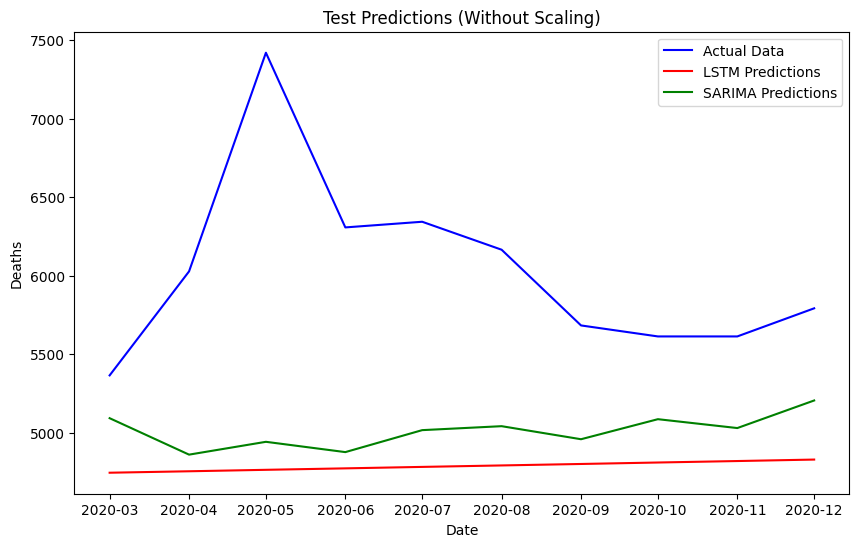

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(plottable.index[61:], plottable['Deaths'][61:], label='Actual Data', color='blue')
plt.plot(plottable.index[61:], plottable['LSTM Predictions'][61:], label='LSTM Predictions', color='red')
plt.plot(plottable.index[61:], plottable['SARIMA Predictions'][61:], label='SARIMA Predictions', color='green')
plt.title('Test Predictions (Without Scaling)')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.show()

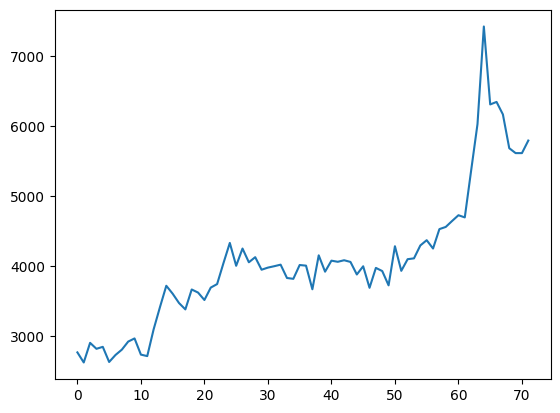

In [4]:
plt.plot(df['Deaths'])

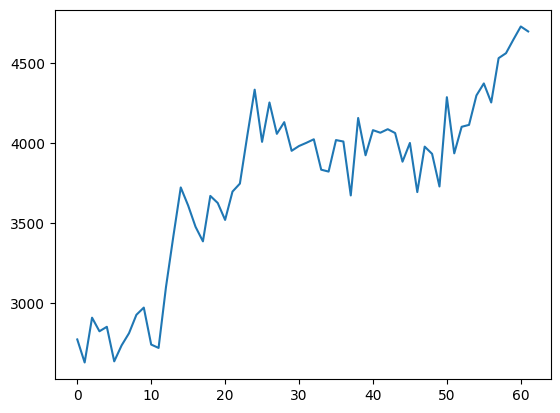

In [5]:
plt.plot(train['Deaths'])

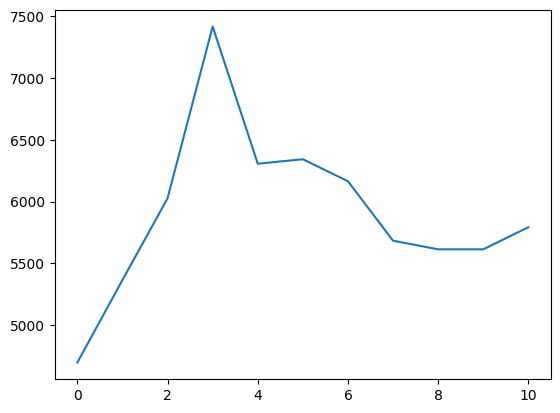

In [6]:
plt.plot(test['Deaths'])

In [8]:
def calculate_confidence_intervals(predictions, alpha=0.05):
    # Calculate mean and standard deviation
    mean_pred = np.mean(predictions)
    std_pred = np.std(predictions)
    
    # Calculate the z-score for the confidence level
    z_score = 1.96  # for 95% confidence
    margin_of_error = z_score * (std_pred / np.sqrt(len(predictions)))
    
    lower_bound = predictions - margin_of_error
    upper_bound = predictions + margin_of_error
    
    return lower_bound, upper_bound

sarimaTestPredict = df[df['Month'] > '2020-01-01']['SARIMA Predictions']
# Calculate confidence intervals
lower_bound_test, upper_bound_test = calculate_confidence_intervals(testPredict)
lower_bound_sarima, upper_bound_sarima = calculate_confidence_intervals(sarimaTestPredict)

In [9]:
def calculate_overlap(lower1, upper1, lower2, upper2):
    # Initialize overlap count
    overlap_count = 0

    for l1, u1, l2, u2 in zip(lower1, upper1, lower2, upper2):
        # Check for overlap
        if u1 >= l2 and l1 <= u2:
            overlap_count += 1

    # Calculate percent overlap
    percent_overlap = (overlap_count / len(lower1)) * 100
    return percent_overlap

# Calculate percent overlap
percent_overlap = calculate_overlap(lower_bound_test, upper_bound_test, lower_bound_sarima, upper_bound_sarima)

print(f'Percent Overlap: {percent_overlap:.2f}%')

Percent Overlap: 20.00%
